<a href="https://colab.research.google.com/github/duy238/Vnindex_predict/blob/main/VnIndex_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split

In [2]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1SA4C8-3RD8Ib8R0IiVKtGv39AJSBVVQy', dest_path='./vnindex2.csv')

# Load and Preprocess Data

In [3]:
dtypes = {'Price': np.float64, 'Open': np.float64, 'High': np.float64, 
          'Low': np.float64, 'Change': np.float64}
train_df = pd.read_csv('vnindex2.csv', dtype=dtypes)

In [4]:
train_df.head()

,Date,Price,Open,High,Low,Vol.,Change
0,6/3/2021,1364.28,1345.21,1366.00,1345.21,898.88K,0.02
1,6/2/2021,1340.78,1337.78,1344.98,1330.82,805.24K,0.00
2,6/1/2021,1337.78,1329.47,1346.34,1328.84,629.42K,0.01
3,5/31/2021,1328.05,1326.65,1328.05,1307.56,737.18K,0.01
4,5/28/2021,1320.46,1307.79,1323.09,1300.06,768.85K,0.01


## Add technical indicators

In [5]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Price'].rolling(window=7).mean()
    dataset['ma21'] = dataset['Price'].rolling(window=21).mean()
    
    # Create MACD
    dataset['26ema'] = dataset['Price'].ewm(span=26,adjust=False).mean()
    dataset['12ema'] = dataset['Price'].ewm(span=12,adjust=False).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
    dataset['20sd'] = dataset['Price'].rolling(window=20).std()
    # dataset['20sd'] = pd.stats.moments.rolling_std(dataset['Price'],20)
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset['Price'].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = dataset['Price'].diff(periods=3)
    
    return dataset

In [6]:
train_df = train_df[::-1].reset_index(drop=True)
train_df.head()

,Date,Price,Open,High,Low,Vol.,Change
0,5/3/2018,1026.46,1018.47,1027.38,1003.79,203.56K,0.00
1,5/4/2018,1026.80,1032.12,1037.02,1022.10,163.07K,0.00
2,5/7/2018,1062.26,1034.64,1062.26,1028.79,155.13K,0.03
3,5/8/2018,1060.45,1061.12,1072.28,1057.24,170.06K,0.00
4,5/9/2018,1056.97,1058.33,1069.80,1051.79,161.33K,0.00


In [7]:
train_df = get_technical_indicators(train_df)
train_df.tail()

,Date,Price,Open,High,Low,Vol.,Change,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
769,5/28/2021,1320.46,1307.79,1323.09,1300.06,768.85K,0.01,1301.348571,1269.348571,1268.961968,1289.948481,20.986513,25.425900,1320.200371,1218.496772,1315.783360,11.88
770,5/31/2021,1328.05,1326.65,1328.05,1307.56,737.18K,0.01,1308.467143,1274.039048,1273.338859,1295.810253,22.471394,27.227607,1328.494262,1219.583834,1323.961120,11.35
771,6/1/2021,1337.78,1329.47,1346.34,1328.84,629.42K,0.01,1316.160000,1278.724286,1278.112277,1302.267137,24.154860,29.331805,1337.387895,1220.060676,1333.173707,34.21
772,6/2/2021,1340.78,1337.78,1344.98,1330.82,805.24K,0.00,1322.274286,1283.418571,1282.754331,1308.192193,25.437862,31.653377,1346.725325,1220.111818,1338.244569,20.32
773,6/3/2021,1364.28,1345.21,1366.00,1345.21,898.88K,0.02,1330.231429,1288.554286,1288.793269,1316.821086,28.027817,35.200886,1358.956058,1218.152513,1355.601523,36.23


In [8]:
train_df.columns

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change', 'ma7', 'ma21',
       '26ema', '12ema', 'MACD', '20sd', 'upper_band', 'lower_band', 'ema',
       'momentum'],
      dtype='object')

In [9]:
print(train_df.shape)

(774, 17)


In [10]:
train_df = train_df.dropna()
train_df.shape

(754, 17)

In [11]:
# Convert string in Volume column into float
def string_to_float(x):
  if 'K' in x:
    return float(x.replace('K','')) * 10**3
  if 'M' in x:
    return float(x.replace('M','')) * 10**6

train_df['Vol.'] = train_df['Vol.'].apply(string_to_float)

In [12]:
train_df['Date'] = pd.to_datetime(train_df['Date'])

In [13]:
train_df.head()

,Date,Price,Open,High,Low,Vol.,Change,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
20,2018-05-31,971.25,947.96,975.51,945.29,182040.0,0.02,963.205714,1015.060476,1003.900268,982.834062,-21.066205,44.759233,1104.578943,925.542009,963.814900,39.50
21,2018-06-01,992.87,973.67,995.06,973.56,204090.0,0.02,963.767143,1013.460952,1003.083211,984.378053,-18.705158,44.910877,1103.282706,923.639199,983.184967,40.69
22,2018-06-04,1013.78,994.48,1013.78,992.01,166090.0,0.02,967.747143,1012.840952,1003.875566,988.901429,-14.974136,43.382826,1099.606604,926.075301,1003.581656,65.28
23,2018-06-05,1022.74,1013.59,1025.26,1011.59,212460.0,0.01,976.152857,1010.959048,1005.272931,994.107363,-11.165568,41.885326,1094.729700,927.188395,1016.353885,51.49
24,2018-06-06,1034.50,1020.97,1034.50,1012.98,162080.0,0.01,990.831429,1009.723333,1007.437899,1000.321615,-7.116284,40.803733,1091.330799,928.115867,1028.451295,41.63


In [14]:
train_df.tail()

,Date,Price,Open,High,Low,Vol.,Change,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
769,2021-05-28,1320.46,1307.79,1323.09,1300.06,768850.0,0.01,1301.348571,1269.348571,1268.961968,1289.948481,20.986513,25.425900,1320.200371,1218.496772,1315.783360,11.88
770,2021-05-31,1328.05,1326.65,1328.05,1307.56,737180.0,0.01,1308.467143,1274.039048,1273.338859,1295.810253,22.471394,27.227607,1328.494262,1219.583834,1323.961120,11.35
771,2021-06-01,1337.78,1329.47,1346.34,1328.84,629420.0,0.01,1316.160000,1278.724286,1278.112277,1302.267137,24.154860,29.331805,1337.387895,1220.060676,1333.173707,34.21
772,2021-06-02,1340.78,1337.78,1344.98,1330.82,805240.0,0.00,1322.274286,1283.418571,1282.754331,1308.192193,25.437862,31.653377,1346.725325,1220.111818,1338.244569,20.32
773,2021-06-03,1364.28,1345.21,1366.00,1345.21,898880.0,0.02,1330.231429,1288.554286,1288.793269,1316.821086,28.027817,35.200886,1358.956058,1218.152513,1355.601523,36.23


In [15]:
train_df = train_df.drop(columns='Change')

Text(0.5, 1.0, 'VnIndex from 05-2018 to 06-2021')

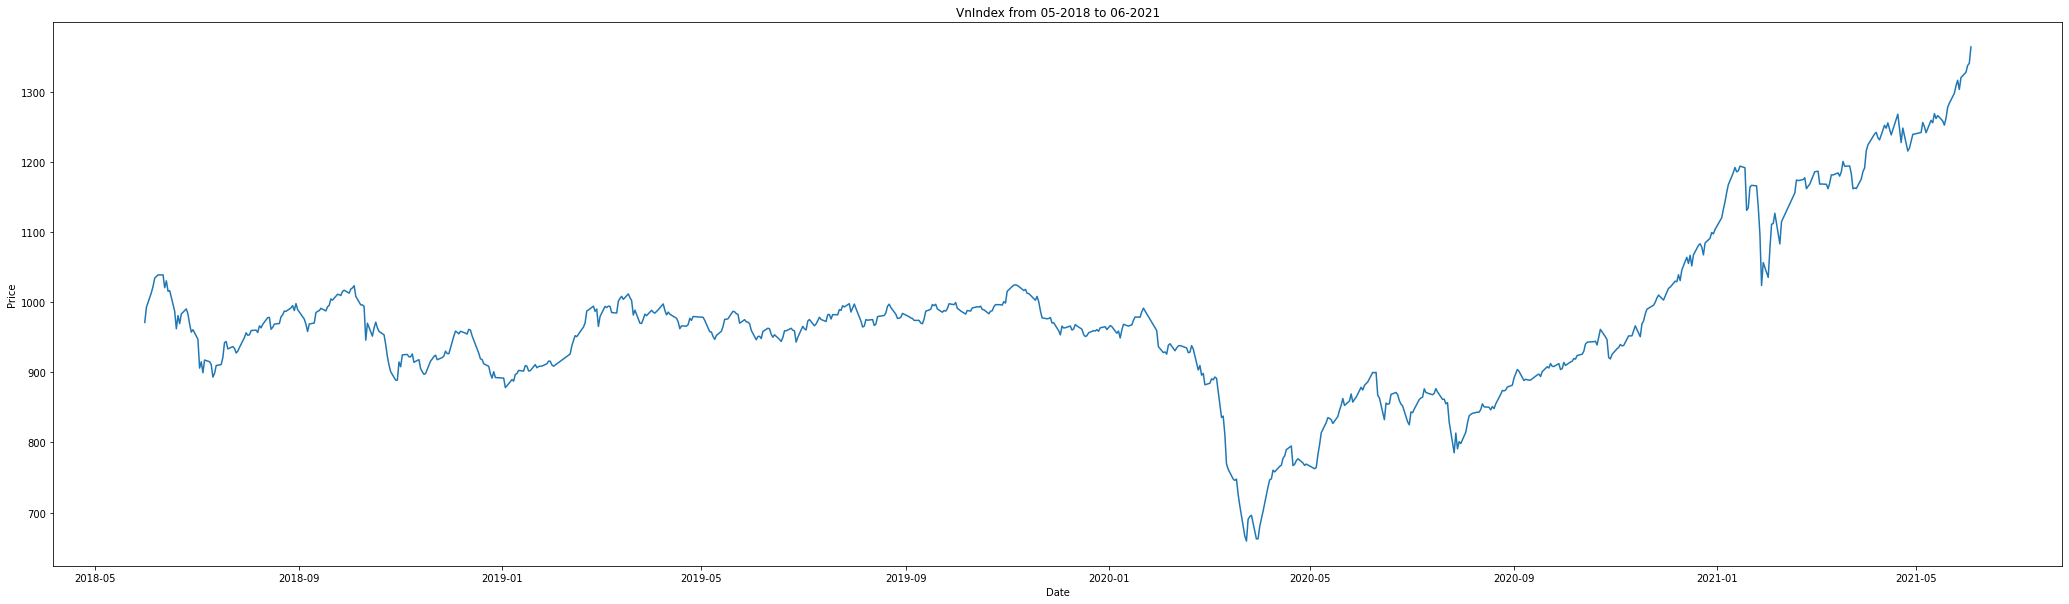

In [16]:
plt.figure(figsize=(36,10))
plt.plot(train_df['Date'], train_df['Price'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('VnIndex from 05-2018 to 06-2021')

## Normalization


In [17]:
from sklearn.preprocessing import MinMaxScaler

In [18]:
scaler = MinMaxScaler(feature_range=(-1,1))

In [19]:
test = train_df.drop(columns='Date')
scaler.fit_transform(test)

array([[-0.11486803, -0.15747148, -0.11498487, ...,  0.04739594,
        -0.136243  ,  0.55681282],
       [-0.05354078, -0.08255999, -0.05916281, ...,  0.04124247,
        -0.08006675,  0.56701384],
       [ 0.00577248, -0.02192567, -0.0057107 , ...,  0.04912054,
        -0.02091314,  0.77780635],
       ...,
       [ 0.92483016,  0.9541382 ,  0.94386386, ...,  0.99983461,
         0.9349558 ,  0.51146543],
       [ 0.93333995,  0.97835113,  0.93998058, ...,  1.        ,
         0.9496621 ,  0.39239638],
       [ 1.        ,  1.        ,  1.        , ...,  0.99366384,
         1.        ,  0.52878145]])

In [20]:
new_train_df = pd.DataFrame(scaler.fit_transform(train_df.drop(columns='Date')), columns=train_df.columns[1:])
new_train_df.insert(0, 'Date', train_df['Date'])

In [21]:
train_df.head()

,Date,Price,Open,High,Low,Vol.,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
20,2018-05-31,971.25,947.96,975.51,945.29,182040.0,963.205714,1015.060476,1003.900268,982.834062,-21.066205,44.759233,1104.578943,925.542009,963.814900,39.50
21,2018-06-01,992.87,973.67,995.06,973.56,204090.0,963.767143,1013.460952,1003.083211,984.378053,-18.705158,44.910877,1103.282706,923.639199,983.184967,40.69
22,2018-06-04,1013.78,994.48,1013.78,992.01,166090.0,967.747143,1012.840952,1003.875566,988.901429,-14.974136,43.382826,1099.606604,926.075301,1003.581656,65.28
23,2018-06-05,1022.74,1013.59,1025.26,1011.59,212460.0,976.152857,1010.959048,1005.272931,994.107363,-11.165568,41.885326,1094.729700,927.188395,1016.353885,51.49
24,2018-06-06,1034.50,1020.97,1034.50,1012.98,162080.0,990.831429,1009.723333,1007.437899,1000.321615,-7.116284,40.803733,1091.330799,928.115867,1028.451295,41.63


In [22]:
new_train_df.head()

,Date,Price,Open,High,Low,Vol.,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
0,NaT,-0.114868,-0.157471,-0.114985,-0.149014,-0.837360,-0.121788,0.042151,-0.065471,-0.088527,-0.205703,0.021422,0.103955,0.047396,-0.136243,0.556813
1,NaT,-0.053541,-0.082560,-0.059163,-0.067791,-0.789582,-0.120072,0.036549,-0.068527,-0.083495,-0.160305,0.025220,0.099389,0.041242,-0.080067,0.567014
2,NaT,0.005772,-0.021926,-0.005711,-0.014782,-0.871920,-0.107907,0.034378,-0.065564,-0.068752,-0.088566,-0.013045,0.086440,0.049121,-0.020913,0.777806
3,NaT,0.031188,0.033755,0.027069,0.041473,-0.771446,-0.082216,0.027787,-0.060338,-0.051785,-0.015335,-0.050545,0.069261,0.052720,0.016128,0.659595
4,NaT,0.064547,0.055259,0.053452,0.045467,-0.880609,-0.037352,0.023459,-0.052241,-0.031532,0.062524,-0.077630,0.057288,0.055719,0.051213,0.575072


Text(0.5, 1.0, 'VnIndex after using scaler')

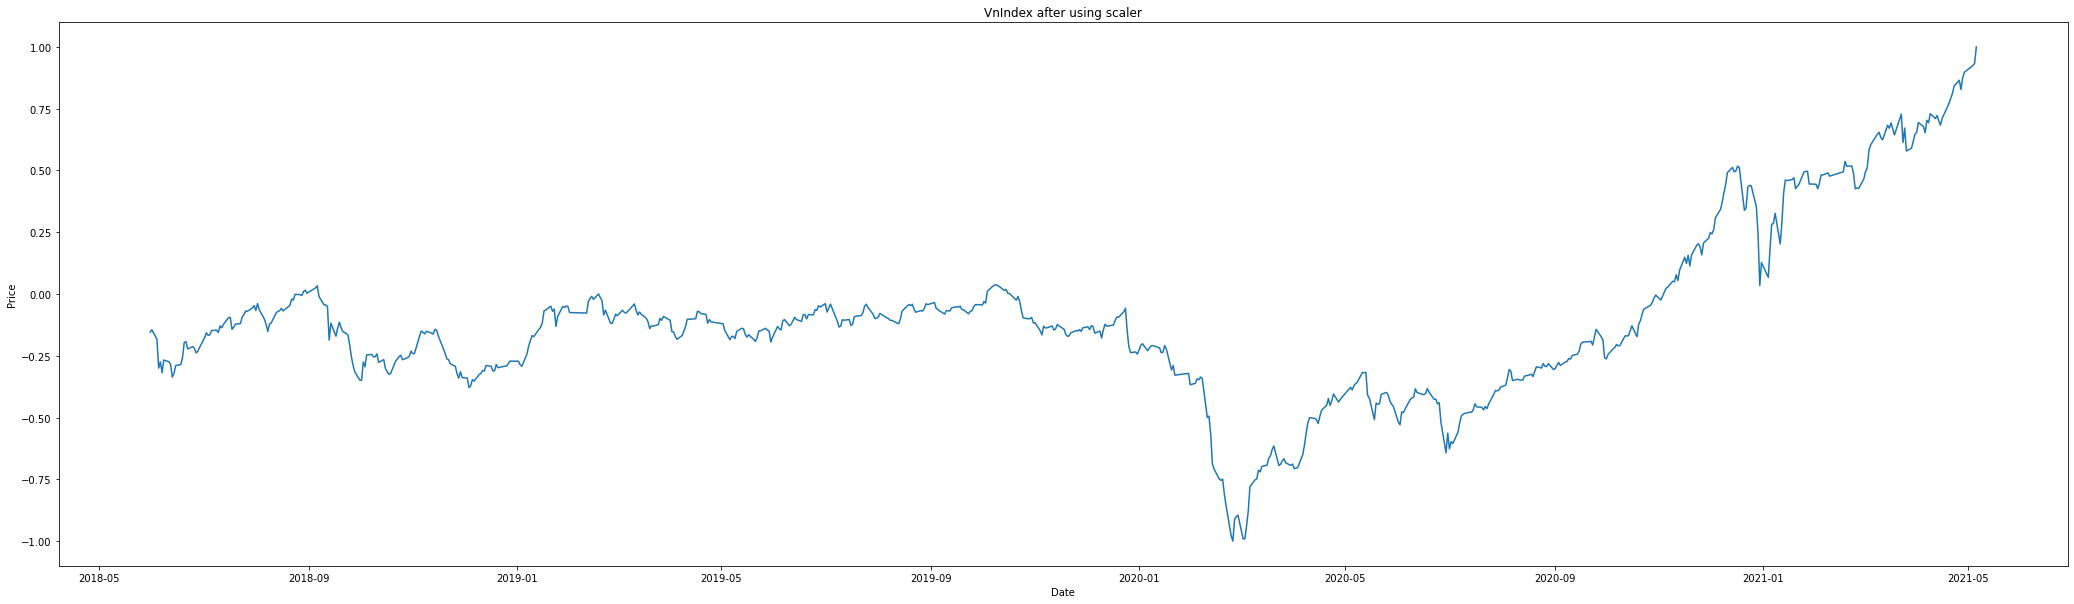

In [23]:
plt.figure(figsize=(36,10))
plt.plot(new_train_df['Date'], new_train_df['Price'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('VnIndex after using scaler')

In [24]:
train_np = new_train_df.drop(columns='Date').to_numpy()

In [25]:
print(train_np)
print(train_np.shape)

[[-0.11486803 -0.15747148 -0.11498487 ...  0.04739594 -0.136243
   0.55681282]
 [-0.05354078 -0.08255999 -0.05916281 ...  0.04124247 -0.08006675
   0.56701384]
 [ 0.00577248 -0.02192567 -0.0057107  ...  0.04912054 -0.02091314
   0.77780635]
 ...
 [ 0.92483016  0.9541382   0.94386386 ...  0.99983461  0.9349558
   0.51146543]
 [ 0.93333995  0.97835113  0.93998058 ...  1.          0.9496621
   0.39239638]
 [ 1.          1.          1.         ...  0.99366384  1.
   0.52878145]]
(754, 15)


## Change data to predict a day block

In [26]:
# Set data as a day block to predict
prediction_days = 20

x_train = []
y_train = []

for x in range(prediction_days, len(train_np)):
  x_train.append(train_np[x-prediction_days:x])
  y_train.append(train_np[x,0])

x_train = np.array(x_train)
y_train = np.array(y_train)

print(x_train.shape)
print(y_train.shape)

(734, 20, 15)
(734,)


In [27]:
x_train, x_test, y_train, y_test= train_test_split(x_train, y_train, test_size=0.2, shuffle=False)

In [28]:
print(y_train.shape)
print(y_test.shape)
print(train_np[-10:])
print(y_test[-5:])

(587,)
(147,)
[[ 0.77207937  0.78913477  0.78022386  0.77948887  0.28263743  0.80471607
   0.8715068   0.85368403  0.82387442  0.45145194 -0.64162338  0.7515662
   0.98444868  0.78079178  0.48609147]
 [ 0.81193357  0.83184977  0.81106162  0.83379064  0.31856298  0.82043048
   0.87646001  0.86706725  0.84152348  0.48676716 -0.59310279  0.77019849
   0.97649034  0.81552292  0.52243796]
 [ 0.8420015   0.86591104  0.83604591  0.86214822  0.23958311  0.8388651
   0.88992873  0.88239563  0.86177229  0.52741916 -0.5115885   0.80667772
   0.96787328  0.84759442  0.47846213]
 [ 0.86503468  0.89169738  0.86094455  0.88355289  0.31327599  0.8641898
   0.90129776  0.89883805  0.88297738  0.56798518 -0.47768029  0.82765195
   0.96961321  0.87398444  0.49912134]
 [ 0.82779015  0.9219417   0.86771172  0.870078    0.35646032  0.88641003
   0.91594057  0.91042512  0.89433658  0.5754274  -0.49134575  0.83853483
   0.98666345  0.85739506  0.26612661]
 [ 0.87570029  0.89096895  0.87747701  0.87027912  0.4

# Train model

In [29]:
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional

In [30]:
EPOCHS = 100
BATCH_SIZE = 32

In [31]:
model = tf.keras.Sequential()
model.add(Bidirectional(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units=50, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units=50, return_sequences=False)))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='Adam', loss='mean_squared_error')

model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/100
19/19 [==============================] - 14s 65ms/step - loss: 0.0128
Epoch 2/100
19/19 [==============================] - 1s 67ms/step - loss: 0.0058
Epoch 3/100
19/19 [==============================] - 1s 65ms/step - loss: 0.0048
Epoch 4/100
19/19 [==============================] - 1s 67ms/step - loss: 0.0035
Epoch 5/100
19/19 [==============================] - 1s 63ms/step - loss: 0.0029
Epoch 6/100
19/19 [==============================] - 1s 65ms/step - loss: 0.0030
Epoch 7/100
19/19 [==============================] - 1s 64ms/step - loss: 0.0037
Epoch 8/100
19/19 [==============================] - 1s 66ms/step - loss: 0.0027
Epoch 9/100
19/19 [==============================] - 1s 62ms/step - loss: 0.0025
Epoch 10/100
19/19 [==============================] - 1s 64ms/step - loss: 0.0024
Epoch 11/100
19/19 [==============================] - 1s 66ms/step - loss: 0.0022
Epoch 12/100
19/19 [==============================] - 1s 69ms/step - loss: 0.0026
Epoch 13/100
19/19 [====

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 20, 100)           26400     
_________________________________________________________________
dropout (Dropout)            (None, 20, 100)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 20, 100)           60400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 100)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100)               60400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

# Predict

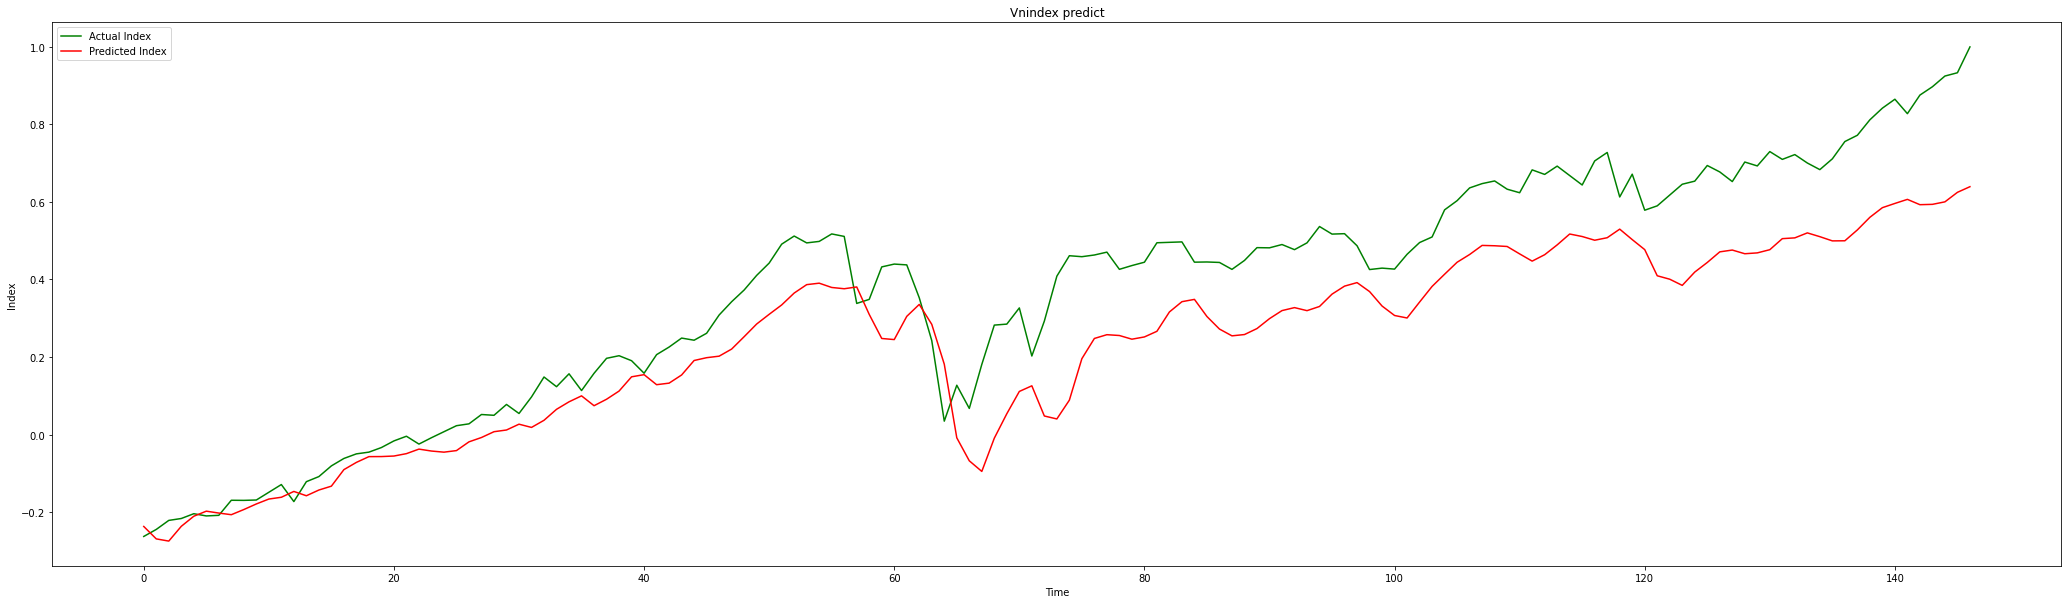

In [33]:
y_predicted = model.predict(x_test)

# Plot
plt.figure(figsize=(36,10))
plt.plot(y_test, color='green', label="Actual Index")
plt.plot(y_predicted, color='red', label="Predicted Index")
plt.title('Vnindex predict')
plt.xlabel('Time')
plt.ylabel('Index')
plt.legend()
plt.show()

## Accuracy

In [34]:
print(y_predicted.shape)
print(y_test.shape)
predict_isup = np.diff(y_predicted, axis=0)
test_isup = np.diff(y_test)

predict_isup = np.where(predict_isup >= 0, 1 ,0).flatten()
test_isup = np.where(test_isup >= 0, 1, 0)
print(predict_isup[:20])
print(test_isup[:20])

(147, 1)
(147,)
[0 0 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1]
[1 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1]


In [35]:
cnt = 0
for i in range(len(predict_isup)):
  if (predict_isup[i] == test_isup[i]):
    cnt+=1
print(f"Accuracy =  {cnt}/{len(predict_isup)} = {cnt/len(predict_isup):.2}")

Accuracy =  82/146 = 0.56


# Conclusion

The model shows random walk symptom. The prediction is almost the same pattern as the actual data but has a delayed time. The data is autocorrelation which means we cannot use this model to predict future data.

To predict future data, the model would need to add more important features, or basically it needs to change to another model to be able to work.